In [ ]:
%load_ext autoreload
%autoreload 2
from xmas_lights.core import read_video, select_frames, filter_frames, \
    digits_from_frame, xy_from_image, init_camera_matrix
from pathlib import Path 
import matplotlib.pyplot as plt
import numpy as np

num_hues = 3
num_bulbs = 50*8
num_flashes = 6
data_folder = Path("../data/Xmas Tree 2025")

caps, pts_xy = [], []
for i, path in enumerate(Path("../data/Xmas Tree 2025").glob("*.mp4")):
    frames, bright, _ = select_frames(read_video(path))
    frames_filt, fg = filter_frames(frames, num_flashes)
    frames_digit = [digits_from_frame(fr, fg, num_hues) for fr in frames_filt]
    im_id = np.sum([(fr.astype(float)*(num_hues**i)) * fg
                    for i, fr in enumerate(frames_digit)], axis=0).astype(int)
    im_id[im_id >= num_bulbs] = 0
    xys, ids, areas = xy_from_image(im_id, fg)
    caps.append({"frames":frames_filt, "bright": bright, "img_id":im_id, 
                 "xys": xys.copy(), "ids": ids.copy(), "file":path.name})
    pts_xy.append(np.ones((num_bulbs, 2)) * np.nan)
    pts_xy[-1][ids] = xys
    print(f"Video {i} found {len(np.unique(im_id))} bulbs")

num_views = len(caps)
cameraMatrix = init_camera_matrix(frames[0])

Frame 0 found 336 bulbs
Frame 1 found 324 bulbs
Frame 2 found 309 bulbs
Frame 3 found 321 bulbs
Frame 4 found 312 bulbs
Frame 5 found 292 bulbs
Frame 6 found 314 bulbs
Frame 7 found 311 bulbs


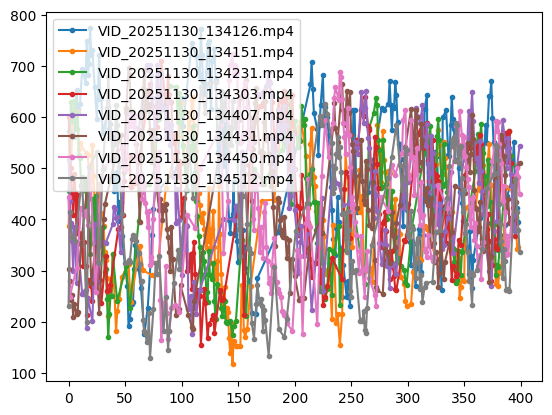

In [2]:
for c in caps:
    plt.plot(c["ids"], c["xys"][:,0], '.-', label=c["file"])
plt.legend()

array([ 48,  61,  76, 184, 201, 207, 209, 216, 232, 267])

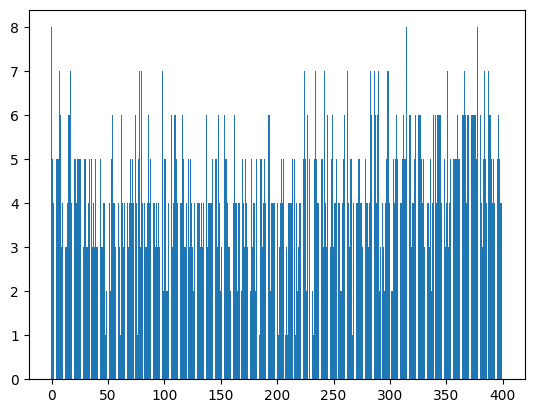

In [3]:
counts = np.bincount(np.concat([c["ids"] for c in caps]))
lbl = np.unique(np.concat([c["ids"] for c in caps]))
counts = counts[lbl]

plt.bar(lbl, counts)
lbl[counts==1]

In [29]:
import cv2 
from typing import List 

def init_camera_pose(pts_xy: List[np.ndarray], cameraMatrix: np.ndarray):
    num_views = len(pts_xy)

    edges = []   # pose-graph edges
    # assume first view camera is origin, compute pose of other views in respect to first
    for i in range(num_views):
        for j in range(num_views):#range(i+1, num_views):
            ids, idxi, idxj = np.intersect1d(caps[i]['ids'], caps[j]['ids'], 
                                            return_indices=True)
            ptsi, ptsj = caps[i]['xys'][idxi], caps[j]['xys'][idxj]
            assert np.all(caps[i]['ids'][idxi] == caps[j]['ids'][idxj]), "oops"

            E, mask = cv2.findEssentialMat(ptsi, ptsj, cameraMatrix=cameraMatrix, 
                                method=cv2.RANSAC, prob=0.995, threshold=3.0)
            ptsi, ptsj = ptsi[mask.ravel() == 1], ptsj[mask.ravel() == 1]
            assert (E is not None) & (E.shape[0] == 3), "No Essential solution"
            _, R, t, _ = cv2.recoverPose(E, ptsi, ptsj, cameraMatrix=cameraMatrix)

            # Normalize scale assuming target has std=1
            P1 = cameraMatrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
            P2 = cameraMatrix @ np.hstack((R, t))

            # Triangulate
            X_h = cv2.triangulatePoints(P1, P2, ptsi.T, ptsj.T)
                                        # ptsi[mask.ravel() == 1].T, 
                                        # ptsj[mask.ravel() == 1].T)
            X = (X_h[:3] / X_h[3]).T
            scale = np.std(X - X.mean(axis=0))

            # get tf0j
            edges.append({"i": i, 
                          "j": j, 
                          "T_ij": np.r_[np.c_[R, t/scale], [[0, 0, 0, 1]]], 
                          "intersect_count": int(sum(mask.flatten())),
                        #   "etc": len(ids)
                          })

    return edges


edges = init_camera_pose(pts_xy, cameraMatrix)
edges

[{'i': 0,
  'j': 0,
  'T_ij': array([[ 1.00000000e+00,  5.55111512e-17,  0.00000000e+00,
           6.58124638e-19],
         [-1.11022302e-16,  1.00000000e+00,  0.00000000e+00,
          -6.58124638e-19],
         [ 5.55111512e-17,  0.00000000e+00,  1.00000000e+00,
           6.58124638e-19],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00]]),
  'intersect_count': 223},
 {'i': 0,
  'j': 1,
  'T_ij': array([[ 6.21433655e-01, -3.61343141e-03,  7.83458458e-01,
          -7.17071256e+00],
         [ 4.00970926e-02,  9.98825557e-01, -2.71979898e-02,
          -1.65566690e-01],
         [-7.82440053e-01,  4.83161525e-02,  6.20848704e-01,
           3.43837927e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00]]),
  'intersect_count': 119},
 {'i': 0,
  'j': 2,
  'T_ij': array([[ 1.58252477e-01, -1.55504477e-02,  9.87276221e-01,
          -9.77016630e+00],
         [ 6.11019618e-02,  9.98113932e-01,  5.92699550e-

In [33]:
num_views = len(pts_xy)
counts = np.zeros((num_views, num_views))
for edge in edges:
    if edge['i'] < edge['j']:
        counts[edge['i'], edge['j']] = edge['intersect_count']

counts

array([[  0., 119.,  96.,  74.,  69.,  59.,  80., 106.],
       [  0.,   0., 134., 101.,  66.,  63.,  57.,  75.],
       [  0.,   0.,   0., 120.,  79.,  64.,  51.,  53.],
       [  0.,   0.,   0.,   0., 146.,  99.,  79.,  67.],
       [  0.,   0.,   0.,   0.,   0., 119.,  80.,  61.],
       [  0.,   0.,   0.,   0.,   0.,   0., 117.,  75.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 111.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [ ]:
import torch 

def torch_least_squares(
    residual_fn,
    x0,
    args=(),
    max_iters=50,
    lr=1.0,
    loss='linear',
    huber_delta=1.0,
    verbose=True,
):
    """
    residual_fn: callable(x, *args) -> residual vector
    x0: (D,) initial torch tensor
    """

    x = x0.clone().detach().requires_grad_(True)

    optimizer = torch.optim.LBFGS(
        [x],
        lr=lr,
        max_iter=20,
        line_search_fn='strong_wolfe'
    )

    def robust_loss(r):
        if loss == 'linear':
            return 0.5 * (r ** 2)
        elif loss == 'huber':
            abs_r = torch.abs(r)
            mask = abs_r < huber_delta
            return torch.where(
                mask,
                0.5 * r**2,
                huber_delta * (abs_r - 0.5 * huber_delta)
            )
        else:
            raise ValueError(f"Unknown loss: {loss}")

    prev_cost = None

    for it in range(max_iters):

        def closure():
            optimizer.zero_grad(set_to_none=True)
            r = residual_fn(x, *args)
            cost = robust_loss(r).sum()
            cost.backward()
            return cost

        cost = optimizer.step(closure)
        cost_val = cost.item()
        # simple convergence check
        if prev_cost is not None and abs(prev_cost - cost_val) < 1e-12:
            break
        
        if verbose and not (it % 10):
            if prev_cost is None:
                print(f"[{it:02d}] cost = {cost_val:.6f}")
            else:
                print(f"[{it:02d}] cost = {cost_val:.6f}  Δ={prev_cost - cost_val:.6f}")
            
        prev_cost = cost_val

    return x.detach()

def se3_to_mat_batch(x):
    """
    x: (N, 6) array
       x[:, :3] = rotvec (rx, ry, rz)
       x[:, 3:] = translation (tx, ty, tz)

    returns: (N, 4, 4) SE(3) matrices
    """

    N = x.shape[0]

    w = x[:, :3]     # rotation vectors
    t = x[:, 3:]     # translations

    theta = torch.linalg.norm(w, axis=1, keepdims=True)  # (N,1)
    theta2 = theta ** 2

    wx, wy, wz = w[:, 0], w[:, 1], w[:, 2]
    zeros = torch.zeros(N)

    W = torch.stack([
        zeros, -wz,    wy,
        wz,     zeros, -wx,
       -wy,     wx,    zeros
    ], dim=1).reshape(N, 3, 3)

    W2 = W @ W
    I = torch.eye(3)[None, :, :]

    eps = 1e-12

    A = torch.where(theta < eps,
                 1.0 - theta2 / 6.0,
                 torch.sin(theta) / theta)

    B = torch.where(theta < eps,
                 0.5 - theta2 / 24.0,
                 (1.0 - torch.cos(theta)) / theta2)

    A = A[:, None]   # (N,1,1)
    B = B[:, None]

    R = I + A * W + B * W2

    T = torch.zeros((N, 4, 4))
    T[:, :3, :3] = R
    T[:, :3, 3] = t
    T[:, 3, 3] = 1.0

    return T

def project_batch(K, T, Xs):
    """
    T: 4x4 (camera poses)
    Xs: Mx3
    """
    R, t = T[:3,:3], T[:3,[3]]
    Xc = (Xs - t.T) @ R
    x = Xc[:,:3] @ K.T
    return x[:,:2] / x[:,[2]]

def ba_residuals_batch(x, obs, num_views, cameraMatrix):
    cam_params = x[:6*(num_views-1)]
    pts  = x[6*(num_views-1):-1].reshape(-1, 3)

    K = cameraMatrix.clone()
    K[0,0] = x[-1]
    K[1,1] = x[-1]

    tfs = torch.concat([torch.eye(4, dtype=x.dtype)[None,:,:], 
                        se3_to_mat_batch(cam_params.reshape(-1, 6))], 0)
    obs_h = torch.stack([project_batch(K, tf, pts) for tf in tfs], 0)
    res = (obs_h - obs).reshape(-1)
    valid = ~torch.isnan(res)

    return res[valid], obs_h


# [camera poses (except first), pts, f]
x1 = torch.as_tensor(np.r_[result.x, pts.flatten(), cameraMatrix[0,0]])
# x1 = solution2.clone()
observations = torch.ones((num_views, num_bulbs, 2)) * np.nan
for i, c in enumerate(caps):
    for j in range(len(c['ids'])):
        observations[i, c['ids'][j],:] = torch.as_tensor(c['xys'][j])
        
dtype = torch.float64
K = torch.as_tensor(cameraMatrix).to(dtype)
observations = observations.to(dtype)
# ba_residuals_batch(x1.to(dtype), observations.to(dtype), num_views, K)

solution2 = torch_least_squares(
    lambda x: ba_residuals_batch(x, observations, num_views, K)[0],
    x1.to(dtype),
    # args=(observations, num_views, K),
    max_iters=500,
    lr=1.0,
    loss='huber',
    huber_delta=1.0,
    verbose=True,
)

In [5]:
from scipy.spatial.transform import Rotation as R
from scipy.optimize import least_squares

def se3_to_mat(x):
    T = np.eye(4)
    T[:3, :3] = R.from_rotvec(x[:3]).as_matrix()
    T[:3, 3] = x[3:]
    return T

def mat_to_se3(T):
    r = R.from_matrix(T[:3, :3]).as_rotvec()
    t = T[:3, 3]
    return np.hstack([r, t])

def invert(T):
    Ti = np.eye(4)
    Ti[:3, :3] = T[:3, :3].T
    Ti[:3, 3] = -Ti[:3, :3] @ T[:3, 3]
    return Ti

def projection_matrix(K, T):
    Rt = np.linalg.inv(T)[:3]   # world → camera
    return K @ Rt

def triangulate_point(obs, poses, K):
    """
    obs = [(cam_idx, xy), ...]
    """
    A = []

    for cam_idx, (u, v) in obs:
        P = projection_matrix(K, poses[cam_idx])
        A.append(u * P[2] - P[0])
        A.append(v * P[2] - P[1])

    A = np.stack(A)
    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]
    return X[:3] / X[3]



def pose_graph_residuals(x, edges, num_views):
    poses = [np.eye(4)]  # camera 0 fixed

    for k in range(1, num_views):
        poses.append(se3_to_mat(x[6*(k-1):6*k]))

    res = []

    for e in edges:
        i, j, T_ij = e["i"], e["j"], e["T_ij"]

        Tij_pred = invert(poses[i]) @ poses[j]
        Terr = invert(T_ij) @ Tij_pred
        res.append(mat_to_se3(Terr))

    return np.concatenate(res)



x0 = np.zeros(6 * (num_views - 1))  # initial guess

result = least_squares(
    pose_graph_residuals,
    x0,
    args=(edges, num_views),
    loss='huber',
    f_scale=1.0,
    verbose=2
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7508e+01                                    5.03e+00    
       1              2         4.1449e+01      6.06e+00       1.00e+00       2.51e+00    
       2              3         3.1214e+01      1.02e+01       2.00e+00       4.76e+00    
       3              4         1.9572e+01      1.16e+01       4.00e+00       4.87e+00    
       4              5         1.6432e+01      3.14e+00       4.00e+00       7.00e+00    
       5              6         6.8341e+00      9.60e+00       1.00e+00       4.80e+00    
       6              7         2.1996e+00      4.63e+00       2.00e+00       1.32e+00    
       7              8         1.5877e+00      6.12e-01       8.30e-01       3.87e-01    
       8              9         1.5616e+00      2.61e-02       9.17e-02       2.22e-02    
       9             10         1.5615e+00      7.97e-05       6.35e-03       1.36e-03    

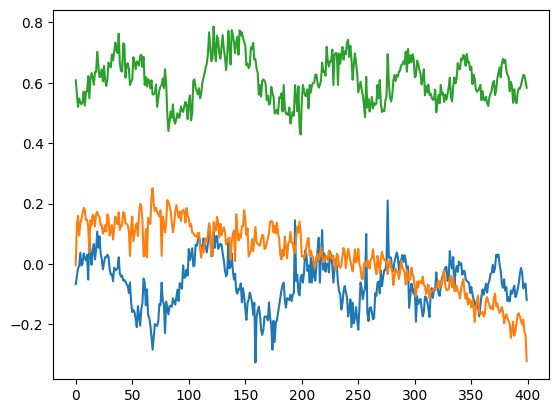

In [7]:
poses = [np.eye(4)]

for k in range(1, num_views):
    poses.append(se3_to_mat(result.x[6*(k-1):6*k]))

all_point_ids = np.unique(np.concat([c["ids"] for c in caps]))
pts = np.zeros([all_point_ids.max()+1, 3])

for pid in all_point_ids:
    obs = []

    for cam_idx in range(num_views):
        if pid in caps[cam_idx]['ids']:
            idx = np.where(caps[cam_idx]['ids'] == pid)[0][0]
            obs.append((cam_idx, caps[cam_idx]['xys'][idx]))

    if len(obs) >= 2:
        pts[pid] = triangulate_point(obs, poses, cameraMatrix)

# pts = np.array(list(points_3d.values()))
# plt.plot(pts[:,1], pts[:,2])
missing = np.all(pts == 0, axis=1)
pts[missing] = np.mean(pts, axis=0)
plt.plot(pts);

In [8]:
def project(K, T, X):
    R, t = T[:3,:3], T[:3,3]
    Xc = R.T @ (X - t)
    # Xc = np.linalg.inv(T) @ np.r_[X, 1]
    x = K @ Xc[:3]
    return x[:2] / x[2]


def ba_residuals(x, observations, num_views, K):
    cam_params = x[:6*(num_views-1)]
    pt_params  = x[6*(num_views-1):-1]
    K[0,0] = x[-1]
    K[1,1] = x[-1]

    poses = [np.eye(4)]
    for i in range(1, num_views):
        poses.append(se3_to_mat(cam_params[6*(i-1):6*i]))

    res = []

    for cam_idx, pt_idx, xy in observations:
        X = pt_params[3*pt_idx:3*(pt_idx+1)]
        x_proj = project(K, poses[cam_idx], X)
        res.append(x_proj - xy)

    return np.concatenate(res)

x1 = np.r_[result.x, pts.flatten(), cameraMatrix[0,0]]
observations = []
for i, c in enumerate(caps):
    for j in range(len(c['ids'])):
        observations.append([i, c['ids'][j], c['xys'][j]])

# observations

# x1
result_ba = least_squares(
    ba_residuals,
    x1,
    args=(observations, num_views, cameraMatrix),
    loss='huber',
    f_scale=1.0,
    max_nfev=10,
    verbose=2
)
# ba_residuals(x1, observations, num_views, cameraMatrix)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4466e+05                                    3.31e+05    


KeyboardInterrupt: 

In [282]:
%%timeit
ba_residuals(x1, observations, num_views, cameraMatrix)

8.53 ms ± 145 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
import torch 

def torch_least_squares(
    residual_fn,
    x0,
    args=(),
    max_iters=50,
    lr=1.0,
    loss='linear',
    huber_delta=1.0,
    verbose=True,
):
    """
    residual_fn: callable(x, *args) -> residual vector
    x0: (D,) initial torch tensor
    """

    x = x0.clone().detach().requires_grad_(True)

    optimizer = torch.optim.LBFGS(
        [x],
        lr=lr,
        max_iter=20,
        line_search_fn='strong_wolfe'
    )

    def robust_loss(r):
        if loss == 'linear':
            return 0.5 * (r ** 2)
        elif loss == 'huber':
            abs_r = torch.abs(r)
            mask = abs_r < huber_delta
            return torch.where(
                mask,
                0.5 * r**2,
                huber_delta * (abs_r - 0.5 * huber_delta)
            )
        else:
            raise ValueError(f"Unknown loss: {loss}")

    prev_cost = None

    for it in range(max_iters):

        def closure():
            optimizer.zero_grad(set_to_none=True)
            r = residual_fn(x, *args)
            cost = robust_loss(r).sum()
            cost.backward()
            return cost

        cost = optimizer.step(closure)
        cost_val = cost.item()
        # simple convergence check
        if prev_cost is not None and abs(prev_cost - cost_val) < 1e-12:
            break
        
        if verbose and not (it % 10):
            if prev_cost is None:
                print(f"[{it:02d}] cost = {cost_val:.6f}")
            else:
                print(f"[{it:02d}] cost = {cost_val:.6f}  Δ={prev_cost - cost_val:.6f}")
            
        prev_cost = cost_val

    return x.detach()

def se3_to_mat_batch(x):
    """
    x: (N, 6) array
       x[:, :3] = rotvec (rx, ry, rz)
       x[:, 3:] = translation (tx, ty, tz)

    returns: (N, 4, 4) SE(3) matrices
    """

    N = x.shape[0]

    w = x[:, :3]     # rotation vectors
    t = x[:, 3:]     # translations

    theta = torch.linalg.norm(w, axis=1, keepdims=True)  # (N,1)
    theta2 = theta ** 2

    wx, wy, wz = w[:, 0], w[:, 1], w[:, 2]
    zeros = torch.zeros(N)

    W = torch.stack([
        zeros, -wz,    wy,
        wz,     zeros, -wx,
       -wy,     wx,    zeros
    ], dim=1).reshape(N, 3, 3)

    W2 = W @ W
    I = torch.eye(3)[None, :, :]

    eps = 1e-12

    A = torch.where(theta < eps,
                 1.0 - theta2 / 6.0,
                 torch.sin(theta) / theta)

    B = torch.where(theta < eps,
                 0.5 - theta2 / 24.0,
                 (1.0 - torch.cos(theta)) / theta2)

    A = A[:, None]   # (N,1,1)
    B = B[:, None]

    R = I + A * W + B * W2

    T = torch.zeros((N, 4, 4))
    T[:, :3, :3] = R
    T[:, :3, 3] = t
    T[:, 3, 3] = 1.0

    return T

def project_batch(K, T, Xs):
    """
    T: 4x4 (camera poses)
    Xs: Mx3
    """
    R, t = T[:3,:3], T[:3,[3]]
    Xc = (Xs - t.T) @ R
    x = Xc[:,:3] @ K.T
    return x[:,:2] / x[:,[2]]

def ba_residuals_batch(x, obs, num_views, cameraMatrix):
    cam_params = x[:6*(num_views-1)]
    pts  = x[6*(num_views-1):-1].reshape(-1, 3)

    K = cameraMatrix.clone()
    K[0,0] = x[-1]
    K[1,1] = x[-1]

    tfs = torch.concat([torch.eye(4, dtype=x.dtype)[None,:,:], 
                        se3_to_mat_batch(cam_params.reshape(-1, 6))], 0)
    obs_h = torch.stack([project_batch(K, tf, pts) for tf in tfs], 0)
    res = (obs_h - obs).reshape(-1)
    valid = ~torch.isnan(res)

    return res[valid], obs_h

x1 = torch.as_tensor(np.r_[result.x, pts.flatten(), cameraMatrix[0,0]])
# x1 = solution2.clone()
observations = torch.ones((num_views, num_bulbs, 2)) * np.nan
for i, c in enumerate(caps):
    for j in range(len(c['ids'])):
        observations[i, c['ids'][j],:] = torch.as_tensor(c['xys'][j])
        
dtype = torch.float64
K = torch.as_tensor(cameraMatrix).to(dtype)
observations = observations.to(dtype)
# ba_residuals_batch(x1.to(dtype), observations.to(dtype), num_views, K)

solution2 = torch_least_squares(
    lambda x: ba_residuals_batch(x, observations, num_views, K)[0],
    x1.to(dtype),
    # args=(observations, num_views, K),
    max_iters=500,
    lr=1.0,
    loss='huber',
    huber_delta=1.0,
    verbose=True,
)

[00] cost = 144657.323236
[10] cost = 75427.589282  Δ=218.676488
[20] cost = 73822.006443  Δ=126.439208
[30] cost = 73158.284879  Δ=21.466767
[40] cost = 73025.826720  Δ=16.153405
[50] cost = 72870.535917  Δ=6.383967
[60] cost = 72843.500723  Δ=1.786631
[70] cost = 72834.638703  Δ=0.309771
[80] cost = 72833.833647  Δ=0.016780
[90] cost = 72833.603271  Δ=0.032971
[100] cost = 72830.773599  Δ=0.466597
[110] cost = 72819.013058  Δ=1.461060
[120] cost = 72721.020134  Δ=34.352859
[130] cost = 71613.734632  Δ=263.346343
[140] cost = 68290.006959  Δ=358.787552
[150] cost = 65846.771717  Δ=306.816059
[160] cost = 63389.326025  Δ=210.882550
[170] cost = 62002.919431  Δ=193.457236
[180] cost = 59891.207467  Δ=134.513787
[190] cost = 59036.472534  Δ=53.287688
[200] cost = 58686.260701  Δ=33.908407
[210] cost = 58250.514907  Δ=68.002029
[220] cost = 57593.293746  Δ=70.594497
[230] cost = 57180.813828  Δ=27.509164
[240] cost = 56906.643945  Δ=23.837717
[250] cost = 56747.319440  Δ=8.678022
[260] co

In [27]:
_, obsh = ba_residuals_batch(solution2, observations, num_views, K)
torch.concat([obsh, observations], dim=-1)

tensor([[[ 390.8200,  917.2329,  573.3000,  916.5000],
         [ 492.1903, 1297.6848,       nan,       nan],
         [ 529.5497, 1242.2655,       nan,       nan],
         ...,
         [ 436.9948,  582.8872,  421.5000,  570.9286],
         [ 401.2691,  541.8410,  394.3448,  555.0000],
         [ 373.1790,  417.8206,       nan,       nan]],

        [[ 386.6314,  865.7966,  386.1667,  961.8333],
         [ 584.1815, 1232.1823,       nan,       nan],
         [ 620.8754, 1188.0808,       nan,       nan],
         ...,
         [ 342.5089,  556.6400,  341.7143,  560.2857],
         [ 341.5175,  515.1532,  346.6364,  549.9091],
         [ 358.3350,  400.3937,       nan,       nan]],

        [[ 457.5412,  856.9422,  454.5714,  668.7857],
         [ 609.3651, 1232.1202,       nan,       nan],
         [ 630.3758, 1190.5956,  630.2059, 1182.4706],
         ...,
         [ 392.0020,  542.9740,       nan,       nan],
         [ 409.4642,  502.2989,       nan,       nan],
         [ 442.9326

In [56]:
0.5 * np.diff(np.quantile((pts1 - np.median(pts1, 0)).flatten(), [0.1, 0.9]))

array([0.05583954])

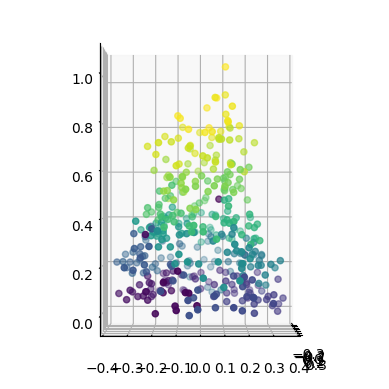

In [103]:
x = solution2
cam_params = x[:6*(num_views-1)].numpy()
pts1  = x[6*(num_views-1):-1].reshape(-1, 3).numpy()
ids = torch.arange(num_bulbs)

# valid = observations.isnan().any(-1).sum(0) > 1
ds1 = np.diff(pts1, axis=0)[1:] / np.diff(ids)[1:,None]
ds2 = np.diff(pts1, axis=0)[:-1] / np.diff(ids)[:-1,None]
DS_MAX = np.diff(np.quantile((pts1 - np.median(pts1, 0)).flatten(), [0.1, 0.9]))

valid = np.concat([[True], 
    (np.sum(ds1**2, 1)**0.5 < DS_MAX) | (np.sum(ds2**2, 1)**0.5 < DS_MAX),
    [True]], 0)

pts1[~valid] = np.array([np.interp(ids[~valid], ids[valid], pts1[valid,i]) for i in range(3)]).T

cov_matrix = np.cov(pts1-np.mean(pts1, 0), rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
pts2 = (pts1-np.mean(pts1, 0)) @ eigenvectors
if np.std(pts2[pts2[:,2] > 0,0]) > np.std(pts2[pts2[:,2] < 0,0]):
    pts2 = pts2 @ np.array([[1, 0, 0],
                            [0, -1, 0],
                            [0, 0, -1]])
pts2[:,2] -= np.quantile(pts2[:,2], 0.001)
pts2 /= np.diff(np.quantile(pts2[:,2], [0.001, 0.999]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # or use fig.add_subplot(projection='3d')
ax.scatter(pts2[:,0], pts2[:,1], pts2[:,2], c=ids, marker='o')
ax.view_init(elev=0., azim=0)
ax.set_aspect('equal')

In [110]:
pts3 = np.round(pts2 * 100).astype(int)
print("const int8_t cartesian[NUM_LEDS][3] = {")
for pt in pts3[:-1]:
    print(f"    {{{pt[0]}, {pt[1]}, {pt[2]}}},")
    # print(f"{{}}")
print(f"    {{{pts3[-1,0]}, {pts3[-1,1]}, {pts3[-1,2]}}}\n}};")

const int8_t cartesian[NUM_LEDS][3] = {
    {1, 8, 48},
    {22, -1, 4},
    {26, -5, 9},
    {22, -10, 18},
    {23, -15, 14},
    {26, -6, 9},
    {24, -10, 2},
    {19, -19, 0},
    {24, -11, 4},
    {13, -16, 9},
    {14, -17, 10},
    {5, -12, 9},
    {19, -23, 33},
    {12, -23, 9},
    {9, -23, 9},
    {10, -22, 5},
    {7, -31, 5},
    {8, -24, 7},
    {3, -27, 7},
    {0, -35, 8},
    {-1, -29, 8},
    {9, -30, 10},
    {5, -22, 13},
    {-3, -23, 15},
    {5, -14, 13},
    {-5, -15, 16},
    {0, -21, 12},
    {1, -26, 12},
    {-5, -20, 7},
    {-5, -21, 6},
    {-2, -12, 17},
    {-4, -15, 12},
    {-12, -22, 9},
    {-14, -12, 13},
    {-19, -16, 16},
    {-29, -18, 8},
    {-24, -16, 11},
    {-20, -16, 12},
    {-20, -14, 11},
    {-11, -8, 15},
    {-25, -3, 14},
    {-25, -3, 14},
    {-30, -8, 8},
    {-25, -7, 8},
    {-28, 4, 11},
    {-20, 0, 16},
    {-17, 0, 9},
    {-14, 8, 17},
    {-5, -2, 14},
    {-3, 6, 11},
    {-12, 21, 5},
    {-12, 18, 13},
    {-15, 19,

In [116]:
np.max(np.abs(pts3[:,:2].flatten())) * 2, \
np.max(np.abs(pts3[:,2].flatten()))

(np.int64(72), np.int64(105))

In [72]:
eigenvalues, eigenvectors

(array([0.00120059, 0.00140331, 0.00255394]),
 array([[ 0.12380783,  0.99221558, -0.01341109],
        [-0.18041667,  0.03579794,  0.98293862],
        [-0.97576711,  0.11927591, -0.1834443 ]]))

In [311]:
%%timeit
ba_residuals_batch(x1, observations, num_views, cameraMatrix)

228 μs ± 6.36 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [300]:
pcs.shape

(10, 400, 2)

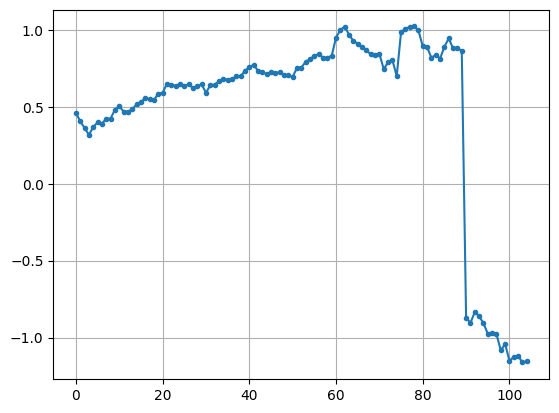

In [124]:
import cv2 
import torch 
import numpy as np 
import matplotlib.pyplot as plt

plt.plot(bright, '.-');
plt.grid();

In [110]:
from xmas_lights.core import filter_frames 

num_flashes = 6
frames_filt, fg = filter_frames(frames, num_flashes)
# frames_filt = [cv2.GaussianBlur(f, (7,7), 0) for f in frames_filt]

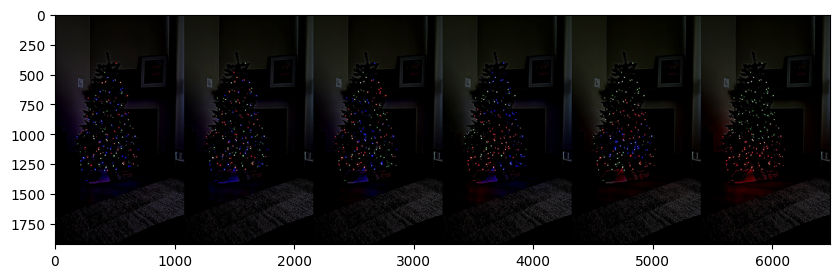

In [111]:
plt.figure(figsize=(10, 4))
plt.imshow(np.concat(frames_filt, axis=1));

In [ ]:
from xmas_lights.core import digits_from_frame 

num_hues = 3
blur = cv2.GaussianBlur(frames_filt[1], (7,7), 0)
frames_digit = [digits_from_frame(fr, fg, num_hues) for fr in frames_filt]

im_id = np.sum([(fr.astype(float)*(num_hues**i)) * fg
                for i, fr in enumerate(frames_digit)], axis=0).astype(int)

num_bulbs = 50*8
im_id[im_id >= num_bulbs] = 0

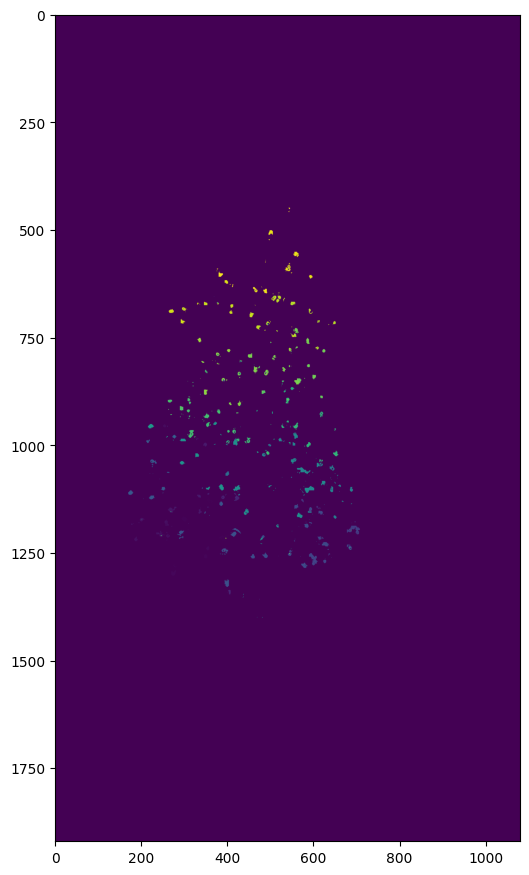

In [ ]:
fig, ax = plt.subplots(figsize=(6, 12))
ax.imshow(im_id);
# ax.imshow((frames_digit[-2] + 1) * fg);

In [ ]:
# %load_ext autoreload
# %autoreload 2
from xmas_lights.core import deriv, xy_from_image 


xys, ids, areas = xy_from_image(im_id, fg)

print(xys.shape, len(np.unique(im_id[fg])))

(216, 2) 312


(216, 2)


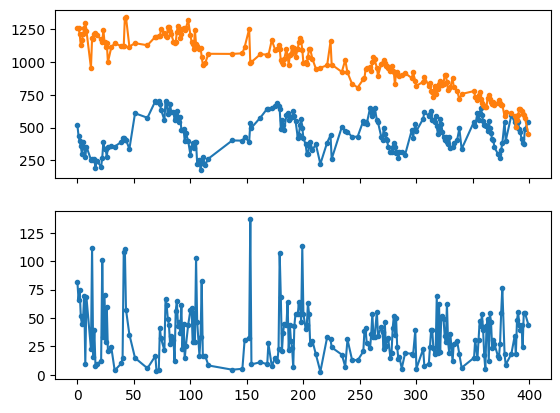

In [ ]:
dxy = np.sum((deriv(xys) / deriv(ids))**2, 1)**0.5

fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].plot(ids, xys, '.-')
axs[1].plot(ids, dxy, '.-')

# deriv(xys)
print(xys.shape)